In [1]:
import numpy as np
import pandas as pd
from xml.dom import minidom

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [3]:
def row_generator(datapath, ddipath):
    ''' Maps each line of the data file to the variables and values
        it represents '''
    # get mapping
    pmap = pos_map(ddipath)
    f = open(datapath, 'r')
    for line in f:
        # apply mapping
        row = {}
        for var in pmap.keys():
            start = pmap[var]['spos']
            end = pmap[var]['epos']
            dec = pmap[var]['dec']
            if dec:
                mid = end - dec
                row[var] = line[start:mid] + '.' + line[mid:end]
            else:
                row[var] = line[start : end]
        # yield mapping
        yield row


def pos_map(ddipath):
    ''' Returns a dictionary mapping the variable names to their positions
        and decimal places in the data file '''
    m = minidom.parse(ddipath)    
    vmap = {}
    varNodes = m.getElementsByTagName('var')
    for varNode in varNodes:
        locNode = varNode.getElementsByTagName('location')[0]
        name = varNode.attributes.getNamedItem('ID').value
        vmap[name] = {
            'spos' : int(locNode.attributes.getNamedItem('StartPos').value) - 1,
            'epos' : int(locNode.attributes.getNamedItem('EndPos').value),
            'dec' : int(varNode.attributes.getNamedItem('dcml').value)
            }
    return vmap

In [4]:
# preprocessing of the data
rows = row_generator(
    datapath = "ipums.dat", 
    ddipath = "ipums.xml"
)

# convert to a dataframe
df = pd.DataFrame(list(rows))

The current dataframe contains all PUMS data across California. Alameda County has a FIPS code of 10, so we'll extract that initially. 

We'll end up with a dataframe describing the PUMS data across Alameda County.

In [5]:
# extract alameda county
alameda = df[(df.COUNTY == '0010')]

# replace empty strings with NaN
alameda = alameda.replace(r'^\s*$', np.nan, regex=True)

# convert strings to numeric values
alameda = alameda.apply(pd.to_numeric)

## Group Quarters vs. Households

First, we want to be sure that we're only taking data from households. The PUMS data distinguishes between 'households' and 'group quarters': in our case, we're only interested in the former, because variables that are necessary for our calculations are not included with the latter.

According to the data dictionary, entries are households when `GQ` is either 1 or 2 (and potentially 5, though I am unsure).

So, let's first extract the households.

In [6]:
households = alameda[(alameda.GQ == 1) | (alameda.GQ == 2)]

The IPUMS data has samplings across households and includes the information about the people in each household. Thus, we'll extract the first person from each household as a representative. 

In [7]:
household_reps = households[households.PERNUM == 1]

## Low-income households

Low-income households in Alameda county scale according to the number of people in the household. We've extracted these thresholds by hand according to the State of California's standards. 

The State of California only provides individual thresholds for households up to 8 members. They have a formula to extend the thresholds for households with 9 or more members, which is captured in the function below. 

In [8]:
def extend_low_income(thres, upper_N=25):
    extras = (np.arange(9, upper_N) - 8) * thres[3] * 0.08 + thres[-1]
    thres = np.append(thres, extras)
    return thres

In [9]:
alameda_low_income = np.array([62750, 71700, 80650, 89600, 96800, 103950, 111150, 118300])
alameda_low_income = extend_low_income(alameda_low_income)

We'll split up the dataframe into low-income and non low-income according to the thresholds above. We have to ensure that we use the correct threshold for each household, accounting for the number of people (using the feature `NUMPREC`). Let's focus on the low income and non low-income households in 2016:

In [54]:
alameda2016 = household_reps[household_reps.YEAR == 2016]

low_income = alameda2016.loc[
    household_reps.HHINCOME < alameda_low_income[household_reps.NUMPREC - 1]
]

non_low_income = alameda2016.loc[
    household_reps.HHINCOME >= alameda_low_income[household_reps.NUMPREC - 1]
]

A quick check that we've properly split up the table:

In [16]:
assert low_income.shape[0] + non_low_income.shape[0] == alameda2016.shape[0]

# Internet Access

To calculate internet access, we'll utilize the variable `CINETHH`, which takes on the values:

- 0: N/A (GQ)
- 1: Yes, with a subscription to an Internet Service
- 2: Yes, without a subscription to an Internet Service
- 3: No Internet access at this house, apartment, or mobile home	

We're particularly interested in 1, which describes households that have an internet subscription. It's unclear what 0 exactly corresponds to, but it's most likely applied to households where the question is not appropriate (e.g. variants of group quarters). Option 0 won't be relevant for us since we've already removed the irrelevant group quarters. 

We're going to calculate internet access by utilizing the `HHWT`, which weights each household according to how representative it is in the sample. Furthermore, we're going to calculate it across each Public Use Microdata Area (PUMA), which are regions within Alameda County for which the PUMS data is subdivided. 

In [35]:
# low income 
total_li = low_income.groupby('PUMA').sum().HHWT
internet_li = low_income[low_income.CINETHH == 1].groupby('PUMA').sum().HHWT
li_internet_proportion = 1 - internet_li/total_li

# non low income
total_nli = non_low_income.groupby('PUMA').sum().HHWT
internet_nli = non_low_income[non_low_income.CINETHH == 1].groupby('PUMA').sum().HHWT
nli_internet_proportion = 1 - internet_nli/total_nli

We can take a look at the internet access rates. The first array gives us the fraction of low-income households across PUMAs that lack access to an internet subscription. The second array gives us the fraction of non low-income households that lack access to an internet subscription.

Observe that there's some spatial modulation to the lack of internet access across PUMAs. 

In [43]:
print('Low Income')
print(li_internet_proportion)
print('\nNon Low-Income')
print(nli_internet_proportion)

Low Income
PUMA
101    0.172702
102    0.322647
103    0.186868
104    0.369341
105    0.256230
106    0.219919
107    0.197886
108    0.160641
109    0.252321
110    0.134505
Name: HHWT, dtype: float64

Non Low-Income
PUMA
101    0.041298
102    0.048530
103    0.030214
104    0.051541
105    0.051750
106    0.062186
107    0.023645
108    0.037865
109    0.025109
110    0.019104
Name: HHWT, dtype: float64


# Desktop Access

We'll proceed similarly as before, this time using `CILAPTOP` to calculate which households have access to a computer. This feature takes on values

- 0: N/A (GQ)
- 1: Yes
- 2: No	

Where 'Yes' denotes that some member of the household member owned or used a desktop, laptop, netbook, or notebook computer. We'll proceed similarly as above, once again ignoring '0' because we've already accounted for Group Quarters.

In [56]:
# low income 
total_li = low_income.groupby('PUMA').sum().HHWT
laptop_li = low_income[low_income.CILAPTOP == 1].groupby('PUMA').sum().HHWT
li_laptop_proportion = 1 - internet_li/total_li

# non low income
total_nli = non_low_income.groupby('PUMA').sum().HHWT
laptop_nli = non_low_income[non_low_income.CILAPTOP == 1].groupby('PUMA').sum().HHWT
nli_laptop_proportion = 1 - internet_nli/total_nli

In [57]:
print('Low Income')
print(li_laptop_proportion)
print('\nNon Low-Income')
print(nli_laptop_proportion)

Low Income
PUMA
101    0.172702
102    0.322647
103    0.186868
104    0.369341
105    0.256230
106    0.219919
107    0.197886
108    0.160641
109    0.252321
110    0.134505
Name: HHWT, dtype: float64

Non Low-Income
PUMA
101    0.041298
102    0.048530
103    0.030214
104    0.051541
105    0.051750
106    0.062186
107    0.023645
108    0.037865
109    0.025109
110    0.019104
Name: HHWT, dtype: float64


# Internet access and Computer Access by Year and PUMA

In [ ]:
puma_labels = [
    r'\textbf{Berkeley \& Albany}',
    r'\textbf{Northwest Oakland \& Emeryville}',
    r'\textbf{East Oakland (Hills) \& Piedmont}',
    r'\textbf{Oakland (South Central)}',
    r'\textbf{San Leandro, Alameda, \& Southwest Oakland}',
    r'\textbf{Castro Valley, San Lorenzo, \& Ashland}',
    r'\textbf{Hayward City}',
    r'\textbf{Union City, Newark, and West Fremont}',
    r'\textbf{East Fremont}',
    r'\textbf{Livermore, Pleasanton, \& Dublin}'
]

In [58]:
def extract_low_income_households(alameda, year):
    # extract survey data for given year
    alameda_by_year = alameda[alameda.YEAR == year]
    
    # extract household representatives
    household_reps = alameda_by_year[alameda_by_year.PERNUM == 1]
    
    # extract households that are low-income
    low_income_table = household_reps.loc[
        household_reps.HHINCOME < alameda_low_income[household_reps.NUMPREC - 1]
    ]
    
    # extract households that are not low-income
    non_low_income_table = household_reps.loc[
        household_reps.HHINCOME >= alameda_low_income[household_reps.NUMPREC - 1]
    ]
    
    return low_income_table, non_low_income_table

In [61]:
def access_to_internet(alameda, years):
    internet_li = np.zeros((len(years), 10))
    internet_nli = np.zeros((len(years), 10))
    for idx, year in enumerate(years):
        low_income, non_low_income = extract_low_income_households(alameda, year=year)
        
        li_removed_NA = low_income[low_income.CINETHH != 0]
        nli_removed_NA = non_low_income[non_low_income.CINETHH != 0]
        
        total_li = li_removed_NA.groupby('PUMA').sum().HHWT
        internet_subscription_li = li_removed_NA[li_removed_NA.CINETHH == 1].groupby('PUMA').sum().HHWT
        
        total_nli = nli_removed_NA.groupby('PUMA').sum().HHWT
        internet_subscription_nli = nli_removed_NA[nli_removed_NA.CINETHH == 1].groupby('PUMA').sum().HHWT
        
        internet_li[idx] = 1 - internet_subscription_li/total_li
        internet_nli[idx] = 1 - internet_subscription_nli/total_nli
        
    return internet_li, internet_nli

In [62]:
def access_to_laptop(alameda, years):
    laptop_li = np.zeros((len(years), 10))
    laptop_nli = np.zeros((len(years), 10))
    for idx, year in enumerate(years):
        low_income, non_low_income = extract_low_income_households(alameda, year=year)
        
        li_removed_NA = low_income[low_income.CILAPTOP != 0]
        nli_removed_NA = non_low_income[non_low_income.CILAPTOP != 0]
        
        total_li = li_removed_NA.groupby('PUMA').sum().HHWT
        owns_laptop_li = li_removed_NA[li_removed_NA.CILAPTOP == 1].groupby('PUMA').sum().HHWT
        
        total_nli = nli_removed_NA.groupby('PUMA').sum().HHWT
        owns_laptop_nli = nli_removed_NA[nli_removed_NA.CILAPTOP == 1].groupby('PUMA').sum().HHWT
        
        laptop_li[idx] = 1 - owns_laptop_li/total_li
        laptop_nli[idx] = 1 - owns_laptop_nli/total_nli
        
    return laptop_li, laptop_nli

In [65]:
internet_li, internet_nli = access_to_internet(alameda, years=[2013, 2014, 2015, 2016])

In [113]:
laptop_li, laptop_nli = access_to_laptop([2013, 2014, 2015, 2016])

# Plots over time

NameError: name 'puma_labels' is not defined

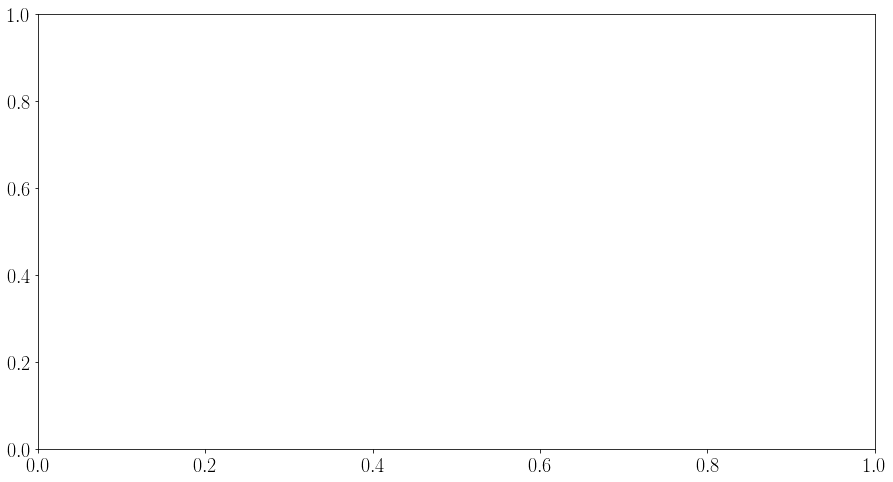

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

[ax.plot(
    np.array([2013, 2014, 2015, 2016]), 
    100 * internet_li[:, idx], 
    linewidth=4, 
    marker='o', 
    markersize=10,
    label=puma_labels[idx]
) for idx in range(10)]
ax.set_xlim([2013, 2016])
ax.set_ylim([10, 40])
ax.set_xticks([2013, 2014, 2015, 2016])
ax.grid(True)
ax.tick_params(labelsize=25)

ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.125),
    fancybox=True, 
    shadow=False, 
    ncol=2,
    prop={'size': 20}
)

ax.set_xlabel(r'\textbf{Year}', fontsize=25)
ax.set_ylabel(r'\textbf{Percentage Lacking}' '\n'  r'\textbf{Internet Subscription}', fontsize=25)
ax.set_title(r'\textbf{Lack of Internet Access Among}' '\n' r'\textbf{Low-Income Residents in Alameda County}', fontsize=30)

#plt.savefig('li_internet.pdf', bbox_inches='tight')

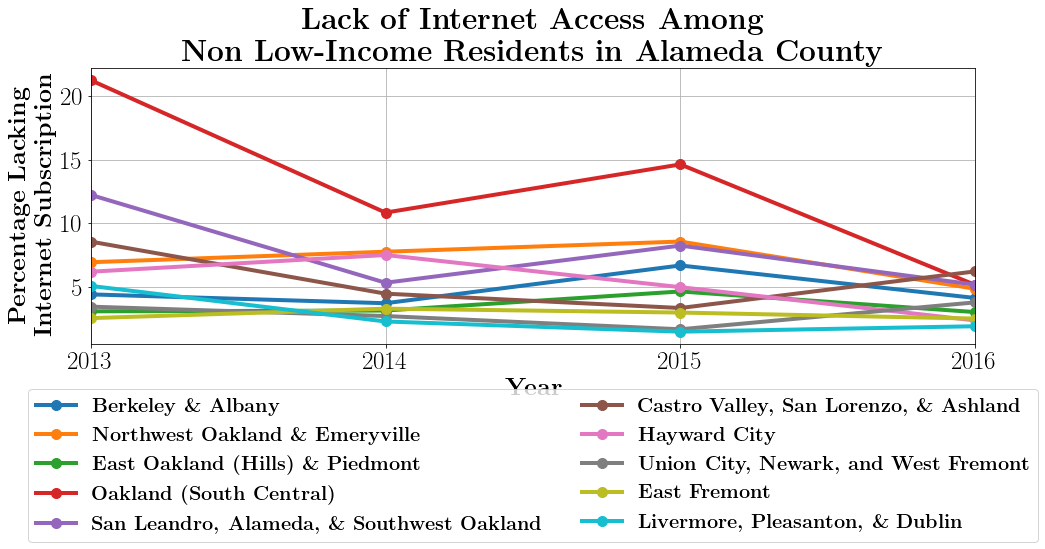

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

[ax.plot(
    np.array([2013, 2014, 2015, 2016]), 
    100 * internet_nli[:, idx], 
    linewidth=4, 
    marker='o', 
    markersize=10,
    label=puma_labels[idx]
) for idx in range(10)]
ax.set_xlim([2013, 2016])
ax.set_xticks([2013, 2014, 2015, 2016])
ax.grid(True)
ax.tick_params(labelsize=25)

ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.125),
    fancybox=True, 
    shadow=False, 
    ncol=2,
    prop={'size': 20}
)

ax.set_xlabel(r'\textbf{Year}', fontsize=25)
ax.set_ylabel(r'\textbf{Percentage Lacking}' '\n'  r'\textbf{Internet Subscription}', fontsize=25)
ax.set_title(r'\textbf{Lack of Internet Access Among}' '\n' r'\textbf{Non Low-Income Residents in Alameda County}', fontsize=30)
plt.tight_layout()
plt.savefig('nli_internet.pdf', bbox_inches='tight')

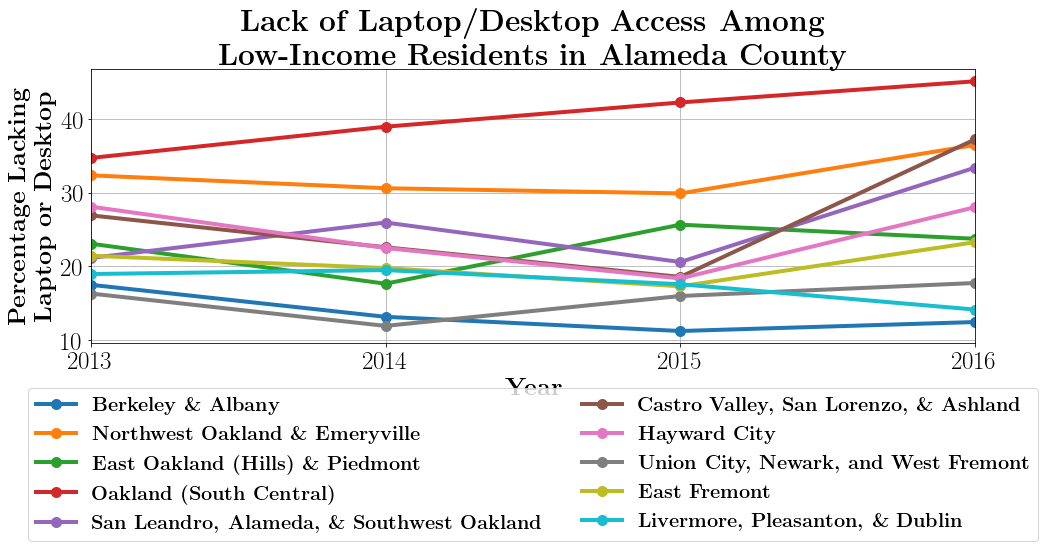

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

[ax.plot(
    np.array([2013, 2014, 2015, 2016]), 
    100 * laptop_li[:, idx], 
    linewidth=4, 
    marker='o', 
    markersize=10,
    label=puma_labels[idx]
) for idx in range(10)]
ax.set_xlim([2013, 2016])
#ax.set_ylim([10, 40])
ax.set_xticks([2013, 2014, 2015, 2016])
ax.grid(True)
ax.tick_params(labelsize=25)

ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.125),
    fancybox=True, 
    shadow=False, 
    ncol=2,
    prop={'size': 20}
)

ax.set_xlabel(r'\textbf{Year}', fontsize=25)
ax.set_ylabel(r'\textbf{Percentage Lacking}' '\n'  r'\textbf{Laptop or Desktop}', fontsize=25)
ax.set_title(r'\textbf{Lack of Laptop/Desktop Access Among}' '\n' r'\textbf{Low-Income Residents in Alameda County}', fontsize=30)
plt.tight_layout()
plt.savefig('li_desktop.pdf', bbox_inches='tight')

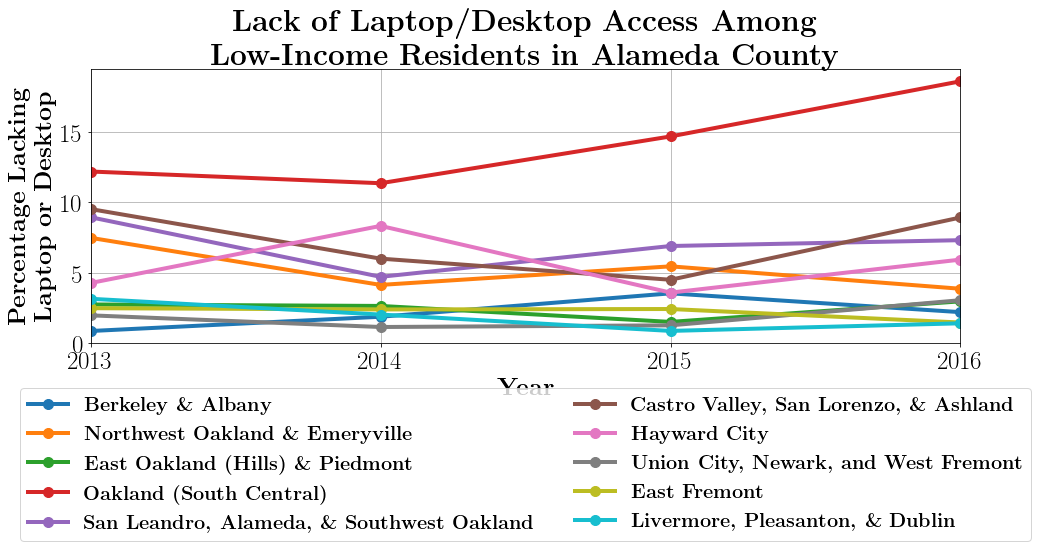

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

[ax.plot(
    np.array([2013, 2014, 2015, 2016]), 
    100 * laptop_nli[:, idx], 
    linewidth=4, 
    marker='o', 
    markersize=10,
    label=puma_labels[idx]
) for idx in range(10)]
ax.set_xlim([2013, 2016])
#ax.set_ylim([10, 40])
ax.set_xticks([2013, 2014, 2015, 2016])
ax.grid(True)
ax.tick_params(labelsize=25)

ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.125),
    fancybox=True, 
    shadow=False, 
    ncol=2,
    prop={'size': 20}
)

ax.set_xlabel(r'\textbf{Year}', fontsize=25)
ax.set_ylabel(r'\textbf{Percentage Lacking}' '\n'  r'\textbf{Laptop or Desktop}', fontsize=25)
ax.set_title(r'\textbf{Lack of Laptop/Desktop Access Among}' '\n' r'\textbf{Low-Income Residents in Alameda County}', fontsize=30)
plt.tight_layout()
plt.savefig('nli_desktop.pdf', bbox_inches='tight')